In [ ]:
#| default_exp diffusion_laziness
# Diffusion Curvature utils
from diffusion_curvature.utils import *
from diffusion_curvature.datasets import *
# Python necessities
import numpy as np
import jax
import jax.numpy as jnp
from fastcore.all import *
import matplotlib.pyplot as plt
# Notebook Helpers
from nbdev.showdoc import *
from tqdm.notebook import trange, tqdm
from fastcore.all import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Diffusion Laziness Estimators
> What's the shape of this diffusion?

# Wasserstein Spread of Diffusion

In [ ]:
#|export
import jax
import jax.numpy as jnp
from jax import jit
import scipy

@jit
def wasserstein_spread_of_diffusion(
                D:jax.Array, # manifold geodesic distances
                Pt:jax.Array, # powered diffusion matrix/t-step ehat diffusions
                ):
        """
        Returns how "spread out" each diffusion is, with wasserstein distance
        Presumes that the manifold distances have been separately calculated
        """
        return jnp.sum(D * Pt, axis=-1)

### Benchmarking

In [ ]:
D = np.random.rand(1000,1000)
Pt = np.random.rand(1000,1000)
Pt = Pt / np.sum(Pt, axis=1)[:,None]

In [ ]:
%%timeit
wasserstein_spread_of_diffusion(D,Pt)

723 µs ± 1.33 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
key = jax.random.PRNGKey(0)
Djax = jax.random.normal(key, (1000, 1000))
key = jax.random.PRNGKey(10)
Ptjax = jax.random.normal(key, (1000, 1000))

In [ ]:
%%timeit
wasserstein_spread_of_diffusion(Djax,Ptjax)

733 µs ± 20.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Wow, it's nearly two orders of magnitude faster when using jax arrays.

# Entropy of Diffusion

In [ ]:
#|export
import jax.scipy
import jax.numpy as jnp

def entropy_of_diffusion(
    Pt:jax.Array, # powered diffusion matrix
    epsilon=1e-5, # threshold for small values, for speed
): 
        """
        Returns the pointwise entropy of diffusion from the powered diffusion matrix in the input
        Assumes that Pt sums to 1
        """
        # Use only the elements of Pt that are greater than epsilon
        Pt = Pt * (Pt>epsilon)
        # Normalize Pt so that it sums to 1
        Pt = Pt / (jnp.sum(Pt, axis=-1) + 1e-12)
        # Pt = (Pt + 1e-10) /(1 + 1e-10*Pt.shape[0]) # ensure, for differentiability, that there are no zeros in Pt, but that it still sums to 1.
        entropy_elementwise = jax.scipy.special.entr(Pt)
        entropy_of_rows = jnp.sum(entropy_elementwise, axis=-1)
        # normalize so max value is 1
        # entropy_of_rows = entropy_of_rows / (-jnp.log(1/jnp.sum(Pt>epsilon, axis=-1)))
        return entropy_of_rows

In [ ]:
from scipy.stats import entropy

In [ ]:
assert jnp.allclose(entropy_of_diffusion(Pt),entropy(Pt,axis=1), atol = 1e-3)

# Diffusion Laziness Model

The above functions estimate the laziness of a powered diffusion matrix, at a single time. Here, we extend the computation over multiple times, as well as making it more convenient to call.

In [ ]:
from diffusion_curvature.heat_diffusion import *

## Divergences and Distances

In [ ]:
# test data
from diffusion_curvature.datasets import sphere
from diffusion_curvature.kernels import *
import scipy

In [ ]:
#|export
@jax.jit
def kl_div(A, B, eps = 1e-12):
    # Calculate Kullback-Leibler divergence
    # get rid of zero values
    A = jnp.where(A == 0, eps, A)
    B = jnp.where(B == 0, eps, B)
    v = A*(jnp.log(A) - jnp.log(B)) 
    return jnp.sum(v)

In [ ]:
test_eq(
    kl_div(Pts[0][1], Pts[10][1]).item(), 
    scipy.special.kl_div(Pts[0][1], Pts[10][1]).sum()
)

In [ ]:
#|export
@jax.jit
def js_dist(
    P:jax.Array, 
    Q:jax.Array,
):
    """Compute the Jensen-Shannon distance between two probability distributions.

    Input
    -----
    P, Q : array-like
        Probability distributions of equal length that sum to 1
    """

    M = 0.5 * (P + Q)

    # Get the JS DIVERGENCE
    result = 0.5 * (kl_div(P, M) + kl_div(Q, M))
    # Take sqrt to get the JS DISTANCE
    return jnp.sqrt(jnp.abs(result))

In [ ]:
assert jnp.allclose(
    js_dist(Pts[0][1], Pts[10][1]).item(), 
    scipy.spatial.distance.jensenshannon(Pts[0][1], Pts[10][1]).sum()
)

One can vectorize these functions with jax.vmap

In [ ]:
js_dist_vectorized = jax.vmap(js_dist, (0, 0), 0)

In [ ]:
vect_output = js_dist_vectorized( Pts[3], Pts[20])
for i, v in enumerate(vect_output):
    test_eq(v, js_dist(Pts[3][i], Pts[20][i]))

## Integrating laziness over time

In [ ]:
ts = np.arange(1,50)
Pts = powers_of_diffusion(P, ts)

We must convert times to distances along the diffusion trajectory.

In [ ]:
#|export
from scipy.spatial.distance import jensenshannon
def diffusion_distances_along_trajectory(diffusions):
    # given a sequence of diffusions, returns the distances between each 
    js_dist_vectorized = jax.vmap(js_dist, (0, 0), 0)
    distances = [jnp.zeros(diffusions[0].shape[0])]
    for idx in range(len(diffusions)-1):
        step_distance = js_dist_vectorized(diffusions[idx+1], diffusions[idx])
        distances.append(
            distances[-1] + step_distance
        )
    return jnp.stack(distances)

In [ ]:
ds = diffusion_distances_along_trajectory(Pts)

In [ ]:
ds.shape

(49, 2000)

We'll use a trapezoidal style integral.

In [ ]:
#|export
import jax
import jax.numpy as jnp

@jax.jit
def trapezoidal_rule(x, y):
    # Ensure x and y are JAX arrays
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    
    # Calculate the differences between consecutive x values along the second axis (axis=1)
    dx = x[:, 1:] - x[:, :-1]
    
    # Calculate the trapezoidal areas along the second axis
    trapezoidal_areas = dx * (y[:, :-1] + y[:, 1:]) / 2
    
    # Sum up the areas along the second axis to get the integral for each row
    integral = jnp.sum(trapezoidal_areas, axis=1)
    
    return integral

In [ ]:
# Example usage
N = 5
M = 1000
x = jnp.linspace(0, 1, M).reshape(1, M).repeat(N, axis=0)  # N x M array of x values
y = x**2  # y = f(x) = x^2 for each row

result = trapezoidal_rule_batch(x, y)
print(result)  # Output should be an array of size N with values close to 1/3 ≈ 0.3333

[0.3333335 0.3333335 0.3333335 0.3333335 0.3333335]


## Diffusion Laziness Wrapper

In [ ]:
#|export
from typing import Literal
from diffusion_curvature.kernels import diffusion_matrix_from_affinities
from diffusion_curvature.heat_diffusion import heat_diffusion_from_dirac, powers_of_diffusion
from copy import deepcopy

class DiffusionLaziness():
    DIFFUSION_TYPES = Literal['diffusion matrix','heat kernel']
    LAZINESS_METHODS = Literal['Entropic', 'Wasserstein']
    def __init__(
        self,
        diffusion_type:DIFFUSION_TYPES = "diffusion matrix",
        laziness_method:LAZINESS_METHODS = "Entropic",
    ):
        store_attr()

    def fit_transform(
        self,
        G, # graph
        ts, # time or list of times.
        idx = None, # supply an integer or list of indices, and we'll only calculate their laziness
        D = None,
        t_dist:int = 25, # diffusion time for distance calculation
    ):
        # get jax affinity matrix, and compute diffusion matrix from graph
        W = G.W
        if scipy.sparse.issparse(W):
            W = W.todense()
        ts = deepcopy(ts)
        if isinstance(ts, int): ts = [ts]
        if D is None: ts += [t_dist]
        W = jnp.array(W)
        # get powers of diffusion
        match self.diffusion_type:
            case 'diffusion matrix':
                P = diffusion_matrix_from_affinities(W)
                Pts = powers_of_diffusion(P, ts)
            case 'heat kernel':
                raise NotImplementedError # TODO: Implement and test
                Pts = heat_diffusion_from_dirac(G, ts)
        match self.laziness_method:
            case "Wasserstein":
                if D is None: D = phate_distances(Pts[-1])
                laziness_with_distance = partial(wasserstein_spread_of_diffusion, D = D)
                laziness_fn = jax.vmap(wasserstein_spread_of_diffusion)
            case "Entropic":
                laziness_fn = jax.vmap(entropy_of_diffusion, (0), 0)
        if D is None: diffusions = Pts[:-1] # the last Pt is for heat 
        if idx is not None: diffusions = [d[idx][None,:] for d in diffusions]
        self.ts = ts[:-1]
        self.ls = laziness_fn(jnp.stack(diffusions)).T 
        self.ds = diffusion_distances_along_trajectory(diffusions).T
        if len(self.ts) > 1: laziness_under_curve = trapezoidal_rule(self.ds, self.ls)
        else:                laziness_under_curve = self.ls
        return laziness_under_curve

In [ ]:
Pts_heat = heat_diffusion_from_dirac(G, [1,2,3,4,5,6,7,10,12])

In [ ]:
Pts_heat.shape

(9, 2000, 2000)

We'll test this with our old friend, the torus.

In [ ]:
X, ks = torus(2000)
G = get_adaptive_graph(X)

2024-07-09 18:30:44,337:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
%%timeit
Laziness_torus = DiffusionLaziness()
ks = Laziness_torus.fit_transform(G, ts = list(range(1,40)))

2.41 s ± 38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
Laziness_torus = DiffusionLaziness()
ks = Laziness_torus.fit_transform(G, ts = list(range(1,40)))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 25]


<3 seconds to calculate 2000 points' curvature isn't bad, though is an order of magnitude faster than the single-diffusion version.

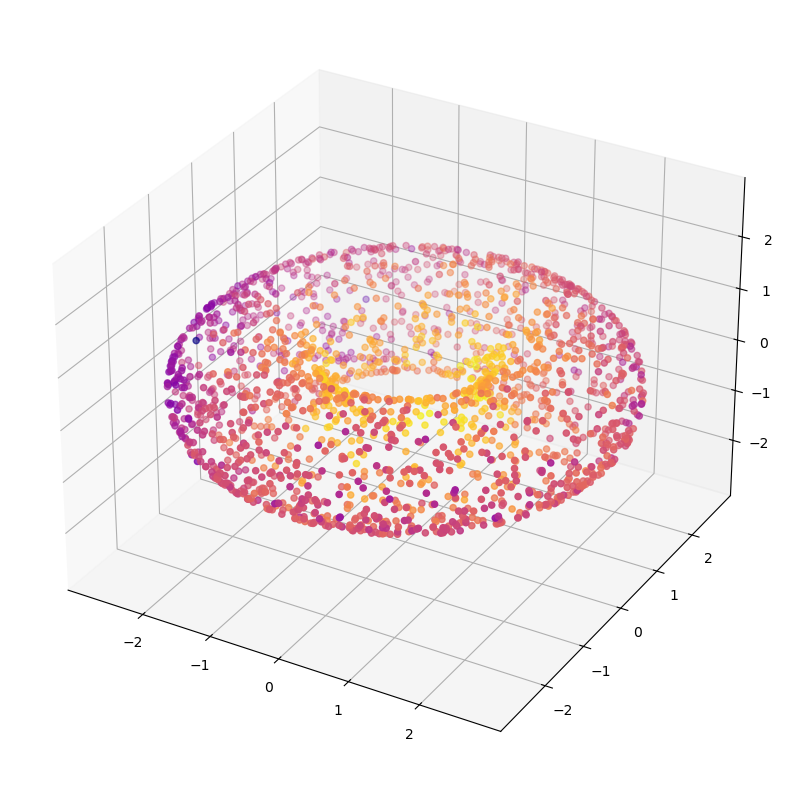

In [ ]:
plot_3d(X, ks)

And the sphere, for comparison

In [ ]:
X_sphere, ks = sphere(2000)
G_sphere = get_adaptive_graph(X_sphere)

2024-07-09 17:47:40,516:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
Laziness_sphere = DiffusionLaziness()
ks_sphere = Laziness_sphere.fit_transform(G_sphere, ts = list(range(1,40)))

In [ ]:
Laziness_sphere.ls.shape

(2000, 39)

In [ ]:
Laziness_sphere.ds.shape

(2000, 39)

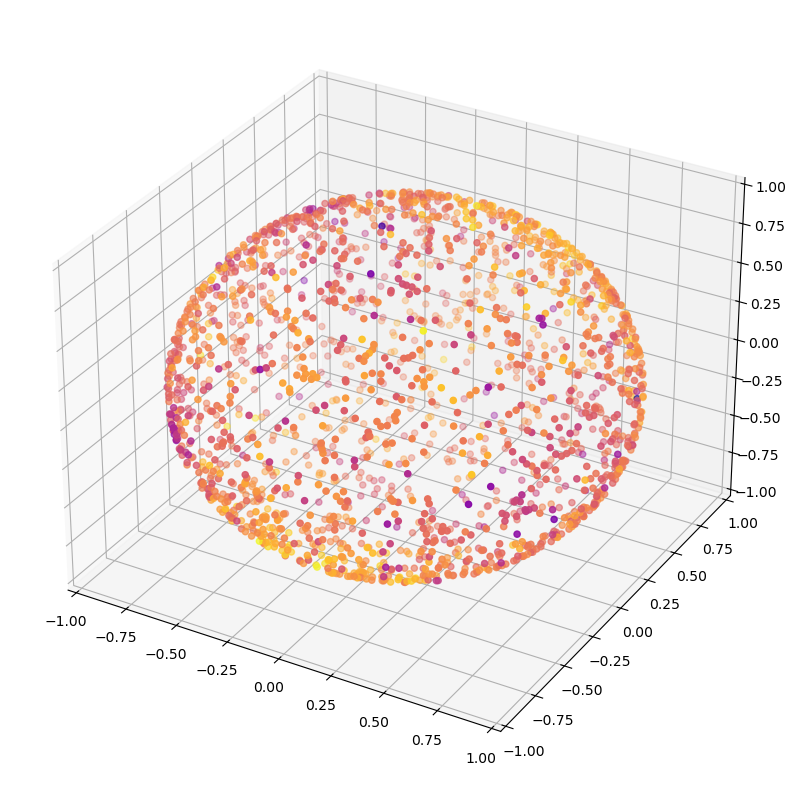

In [ ]:
plot_3d(X_sphere, ks_sphere)

Single idx testing:

In [ ]:
Laziness_single_idx = DiffusionLaziness()
k = Laziness_single_idx.fit_transform(G, list(range(1,40)), idx = 1)

In [ ]:
k

Array([6.1568594], dtype=float32)

In [ ]:
Laziness_single_idx = DiffusionLaziness()
k = Laziness_single_idx.fit_transform(G, list(range(1,40)), idx = 0)

In [ ]:
k

Array([6.04713], dtype=float32)

It is surprisingly quicker with a single index, even though it currently still computes all of the matrix powers. What's the slowest part?

In [ ]:
%%timeit
Laziness_single_idx = DiffusionLaziness()
k = Laziness_single_idx.fit_transform(G, list(range(1,40)), idx = 0)

524 ms ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Does it work with a single time?

In [ ]:
Laziness_single_idx = DiffusionLaziness()
k = Laziness_single_idx.fit_transform(G, [5], idx = 0)
k

Array([[4.8297405]], dtype=float32)

## Visualization Utils

In [ ]:
#|export
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from fastcore.all import *
from tqdm.auto import tqdm
import inspect

def curvature_curves(*diffusion_curvatures, idx=0, title="Curvature Curves", also_plot_against_time = False, **kwargs):
    if also_plot_against_time: fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    else:                      fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    for dc in diffusion_curvatures:
        dc_name = None
        for frame_record in inspect.stack():
            frame = frame_record.frame
            for name, obj in frame.f_globals.items():
                if obj is dc:
                    dc_name = name
            for name, obj in frame.f_locals.items():
                if obj is dc:
                    dc_name = name
        if dc_name is None:
            dc_name = "Unknown"
        
        t_values, distances, curvatures = dc.ts, dc.ds[idx], dc.ls[idx]
        axs[0].plot(distances, curvatures, label=dc_name)
        if also_plot_against_time: axs[1].plot(t_values, curvatures, label=dc_name)
        
    axs[0].set_title("Spread of diffusion vs distance along diffusion trajectory")
    axs[0].set_xlabel('Distance')
    axs[0].set_ylabel('Spread of diffusion')
    if also_plot_against_time:
        axs[1].set_title("Spread of diffusion vs time")
        axs[1].set_xlabel('Time ($t$)')    
        axs[1].set_ylabel('Spread of diffusion')
        axs[1].legend()
    fig.suptitle(title)
    axs[0].legend()
    plt.show()

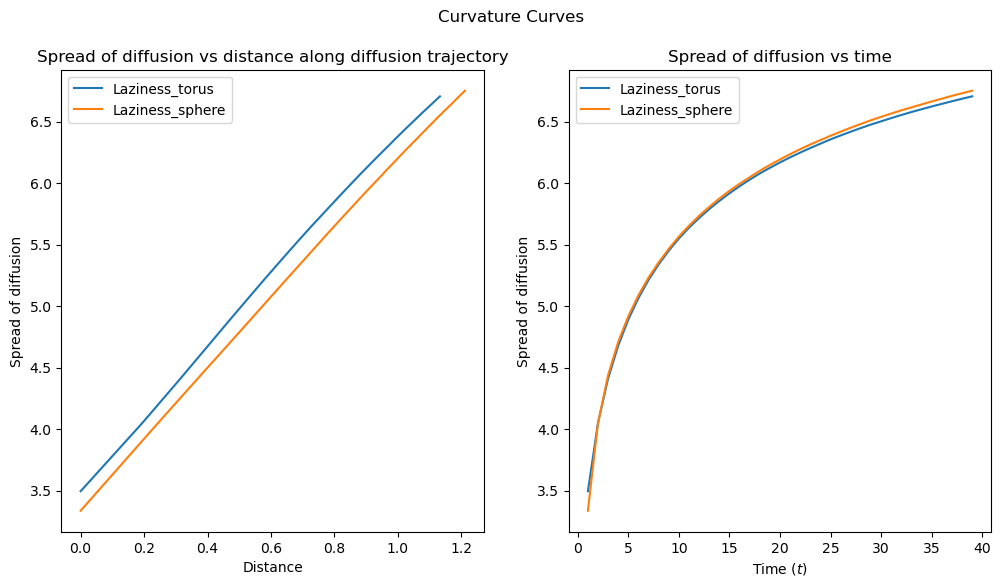

In [ ]:
curvature_curves(Laziness_torus, Laziness_sphere, also_plot_against_time = True)

In [ ]:
!pixi run nbsync

✨ Pixi task (nbsync in default): nbdev_export
⠁ activating environment                                                                 